In [72]:
import pendulum

import geopandas as gpd
from google.cloud import storage
import gcsfs

import seaborn as sns
import os

import numpy as np
import pandas as pd
import osmnx

from scipy import stats

import fiona
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os, time, math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, cross_validate

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [74]:
# Helper Function
def rmse(predictions, targets, **kwargs):
    return np.sqrt(mean_squared_error(targets, predictions))


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
# src: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn


def mean_absolute_percentage_error(y_true, y_pred, **kwargs):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Create a custom scorer based on MAPE. This is used in GridSearchCV. Also
# used in sklearn, since that package does not offer MAPE as a scorer.
MAPE_SCORER = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
MAE_SCORER = make_scorer(mean_absolute_error, greater_is_better=False)
RMSE_SCORER = make_scorer(rmse, greater_is_better=False)
MSE_SCORER = make_scorer(mean_squared_error, greater_is_better=False)
R2_SCORER = make_scorer(r2_score, greater_is_better=True)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [75]:
# read the indices
ind=pd.read_csv('D:/Bike_ped Exposure Model Project/Processed Data/Updated_indices.csv')
ind.head()

,Unnamed: 0.1,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,...,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,Field1,location_y,AADBT,no_of_mont,type
0,0,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,NaN,NaN,0.0,urban,53.547619,12.0,eco_permanent
1,1,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,NaN,NaN,1.0,urban,54.495040,12.0,eco_permanent
2,2,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,NaN,NaN,2.0,urban,52.724206,12.0,eco_permanent
3,3,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,NaN,NaN,3.0,urban,48.792659,12.0,eco_permanent
4,4,671,2017,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,1.020619,...,NaN,NaN,NaN,NaN,NaN,0.0,urban,53.547619,12.0,eco_permanent


In [76]:
count_sites=ind

In [77]:
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.longitude, count_sites.latitude)

count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')

In [78]:
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

In [79]:
#read Block group
block_groups_CA = gpd.read_file('D:/Bike_ped Exposure Model Project/CA Block Group/nhgis0097_shape/nhgis0097_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('D:/Bike_ped Exposure Model Project/Nevada Block Group/nhgis0098_shape/nhgis0098_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272
060014002002,G06000104002002,06,001,400200,2,Block Group 2,G5030,S,298490.0,0.0,+37.8465865,-122.2503095,3162.343955,2.984887e+05,"POLYGON ((-2258439.130 352894.146, -2258619.65...",0.115297
060014003001,G06000104003001,06,001,400300,1,Block Group 1,G5030,S,265695.0,0.0,+37.8439848,-122.2486668,2553.074982,2.656948e+05,"POLYGON ((-2258662.984 352641.307, -2258755.16...",0.102629
060014003002,G06000104003002,06,001,400300,2,Block Group 2,G5030,S,269347.0,0.0,+37.8362550,-122.2516875,3534.834596,2.693459e+05,"POLYGON ((-2259955.644 352133.337, -2259945.80...",0.104040


In [80]:
block_groups.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Leng', 'Shape_Area', 'geometry', 'aland_sqmi'],
      dtype='object')

In [81]:
block_groups.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [82]:
bg_pop = pd.read_csv('D:/Bike_ped Exposure Model Project/CA and Ne Pop/nhgis0099_csv/nhgis0099_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138
060014002002,G06000104002002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002002,NaN,NaN,"Block Group 2, Census Tract 4002, Alameda Coun...",1017,"Block Group 2, Census Tract 4002, Alameda Coun...",123
060014003001,G06000104003001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003001,NaN,NaN,"Block Group 1, Census Tract 4003, Alameda Coun...",1134,"Block Group 1, Census Tract 4003, Alameda Coun...",238
060014003002,G06000104003002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003002,NaN,NaN,"Block Group 2, Census Tract 4003, Alameda Coun...",1237,"Block Group 2, Census Tract 4003, Alameda Coun...",263


In [83]:
block_groups = block_groups.join(bg_pop[['pop']])

In [84]:
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [85]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

<AxesSubplot:xlabel='popden', ylabel='Average_WWI'>

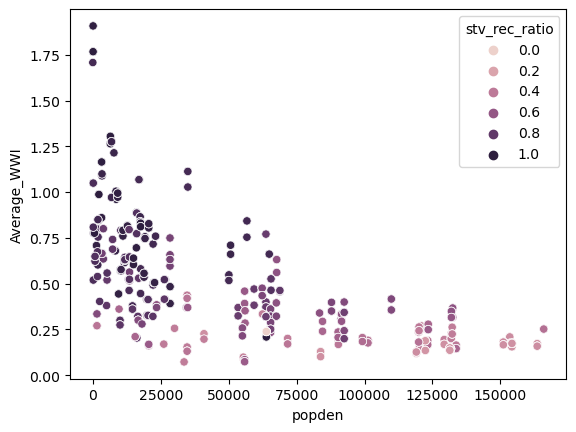

In [86]:
sns.scatterplot(data=count_sites[count_sites.Average_WWI < 10], x='popden', y='Average_WWI', hue='stv_rec_ratio')

<AxesSubplot:xlabel='popden', ylabel='max_weekday_am_pm_value'>

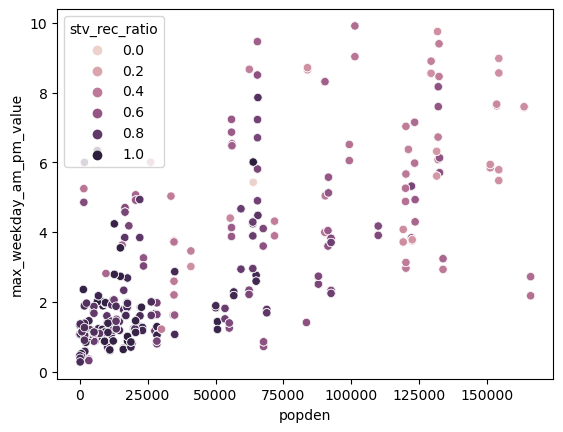

In [87]:
# weekday Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekday_am_pm_value < 10], x='popden', y='max_weekday_am_pm_value', hue='stv_rec_ratio')

<AxesSubplot:xlabel='popden', ylabel='max_weekend_am_pm_Value'>

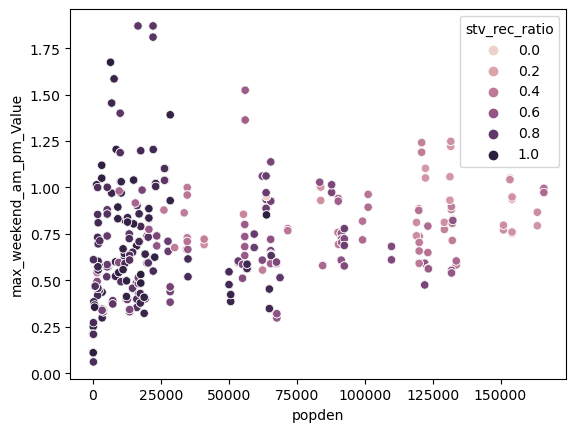

In [88]:
# weekend Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekend_am_pm_Value< 3], x='popden', y='max_weekend_am_pm_Value', hue='stv_rec_ratio')

In [89]:
count_sites.shape

(2159, 46)

In [90]:
count_sites = count_sites.reset_index(level=0)
count_sites = count_sites.reset_index(level=0)

In [91]:
count_sites.head()

,year,ID,Unnamed: 0.1,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,...,stv_rec_total,stv_com_ratio,stv_rec_ratio,Field1,location_y,AADBT,no_of_mont,type,geometry,popden
0,2016,671,0,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,0.0,urban,53.547619,12.0,eco_permanent,POINT (-216265.861 -22230.259),50711.833599
1,2016,671,1,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,1.0,urban,54.495040,12.0,eco_permanent,POINT (-216265.861 -22230.259),50711.833599
2,2016,671,2,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,2.0,urban,52.724206,12.0,eco_permanent,POINT (-216265.861 -22230.259),50711.833599
3,2016,671,3,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,NaN,NaN,NaN,3.0,urban,48.792659,12.0,eco_permanent,POINT (-216265.861 -22230.259),50711.833599
4,2017,671,4,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,1.020619,...,NaN,NaN,NaN,0.0,urban,53.547619,12.0,eco_permanent,POINT (-216265.861 -22230.259),50711.833599


# Develop the 10 fold CV Linear Regression model

In [114]:
def ln_model(X, Y):
    # Now we do 10fold cv without library
    num_folds = 10
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)

    # Now we perform KFold:

    fold_num = 1
    lr_MAPE_train = []
    lr_MAPE_scores = []
    lr_RMSE_train = []
    lr_RMSE_scores = []
    lr_MAE_train = []
    lr_MAE_scores = []
    lr_R2_train = []
    lr_R2_scores = []
    test_pred = []
    # we split the entire dataframe:
    for train, test in kfold.split(X, Y):
        lr_CV_model = LinearRegression().fit(X[train], Y[train])
        train_predictions = lr_CV_model.predict(X[train])
        test_predictions = lr_CV_model.predict(X[test])
        predictions_df=dataset = pd.DataFrame(np.hstack((lr_CV_model.predict(X[test]), Y[test].reshape(-1, 1))))
        train_mape = mean_absolute_percentage_error(Y[train], train_predictions)
        lr_MAPE_train.append(train_mape)
        test_mape = mean_absolute_percentage_error(Y[test], test_predictions)
        lr_MAPE_scores.append(test_mape)
        train_rmse = math.sqrt(mean_squared_error(Y[train], train_predictions))
        lr_RMSE_train.append(train_rmse)
        test_rmse = math.sqrt(mean_squared_error(Y[test], test_predictions))
        lr_RMSE_scores.append(test_rmse)
        train_mae = mean_absolute_error(Y[train], train_predictions)
        lr_MAE_train.append(train_mae)
        test_mae = mean_absolute_error(Y[test], test_predictions)
        lr_MAE_scores.append(test_mae)
        train_r2 = r2_score(Y[train], train_predictions)
        lr_R2_train.append(train_r2)
        score_r2 = r2_score(Y[test], test_predictions)
        lr_R2_scores.append(score_r2)
        test_pred.append(predictions_df)
        appended_data=pd.concat(test_pred)
        print(
            f"------------------------------------------Fold {fold_num}------------------------------------------")
        print(f"\tTrain MAE: {train_mae}\tScore Loss: {test_mae}")
        print(f"\tTrain RMSE: {train_rmse}\tScore RMSE: {test_rmse}")
        print(f"\tTrain MAPE: {train_mape}\tScore MAPE: {test_mape}")
        print(f"\tTrain R2:   {train_r2}\tScore R2: {score_r2}")
        fold_num += 1

    print(f"\n\nOverall MAE: {np.mean(lr_MAE_scores)} +/- {np.std(lr_MAE_scores)}")
    print(f"Overall RMSE: {np.mean(lr_RMSE_scores)} +/- {np.std(lr_RMSE_scores)}")
    print(f"Overall MAPE: {np.mean(lr_MAPE_scores)} +/- {np.std(lr_MAPE_scores)}")
    print(f"Overall R2: {np.mean(lr_R2_scores)} +/- {np.std(lr_R2_scores)}\n\n")

    print("Delimited table for linear Regression 10 fold:")
    print("MAPE\tRMSE\tMAE\tR2")
    for i in range(0, 10):
        print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f" %
              (lr_MAPE_train[i], lr_MAPE_scores[i], lr_RMSE_train[i], lr_RMSE_scores[i], lr_MAE_train[i], lr_MAE_scores[i], lr_R2_train[i], lr_R2_scores[i]))
    print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t<===Averages" % (np.mean(lr_MAPE_train), np.mean(lr_MAPE_scores), np.mean(lr_RMSE_train),
          np.mean(lr_RMSE_scores), np.mean(lr_MAE_train), np.mean(lr_MAE_scores), np.mean(lr_R2_train), np.mean(lr_R2_scores)))
    print(f"lr_rf_fs_CV_model.coef_ ==\n{lr_CV_model.coef_}")
    print(f"\nlr_rf_fs_CV_model.intercept_ == {lr_CV_model.intercept_}")
    appended_data.to_csv('appended_data.csv',index=False)

In [115]:
data=count_sites.loc[count_sites['Average_WWI'] < 1.5]
data1=data[(data.year==2018)|(data.year==2019)]
X_data=data1[['popden','stv_rec_ratio']]
Y_data=data1[['Average_WWI']]

In [116]:
scoring = {'mean_absolute_error': MAE_SCORER,
           'mean_squared_error': MSE_SCORER,
           'r2': R2_SCORER,
           'mean_absolute_percentage_error': MAPE_SCORER}

In [117]:
# # use the Sklearn library to run linear regression model
# lm = LinearRegression()
# # create a KFold object with 5 splits 
# folds = KFold(n_splits = 10, shuffle = True, random_state = 1)
# scores = cross_validate(lm, X_data, Y_data, cv=5,
#                         scoring=scoring, return_train_score=True)
# sorted(scores.keys())

In [118]:
# print(
#     f"Training MAPE:  {(-scores['train_mean_absolute_percentage_error']).mean()}\tTesting MAPE: {(-scores['test_mean_absolute_percentage_error']).mean()}")
# print(
#     f"Training RMSE: {(np.sqrt(-scores['train_mean_squared_error'])).mean()}\tTesting RMSE: {(np.sqrt(-scores['test_mean_squared_error'])).mean()}")
# print(
#     f"Training MAE:  {(-scores['train_mean_absolute_error']).mean()}\tTesting MAE: {(-scores['test_mean_absolute_error']).mean()}")
# print(
#     f"Training R2:   {(scores['train_r2']).mean()}\tTesting R2: {(scores['test_r2']).mean()}")



In [119]:
X = np.asarray(X_data)
Y = np.asarray(Y_data)

In [125]:
ln_model(X, Y)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.12476000792235496	Score Loss: 0.14347542696635654
	Train RMSE: 0.16629442376560089	Score RMSE: 0.1847994823340388
	Train MAPE: 35.88663913921103	Score MAPE: 36.5826831866244
	Train R2:   0.6332792308699045	Score R2: 0.6216520228482246
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.1283256670232646	Score Loss: 0.1152520150361795
	Train RMSE: 0.1700917036753112	Score RMSE: 0.15029837748424513
	Train MAPE: 37.20269167909861	Score MAPE: 29.694090606390866
	Train R2:   0.6284988707178645	Score R2: 0.6724418197604423
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.12652890395047856	Score Loss: 0.13112216806183244
	Train RMSE: 0.1672647967587217	Score RMSE: 0.17654340147204386
	Train MAPE: 35.855025394924326	Score MAPE: 41.45306186109457
	Train R2:   0.6330750064694366	Score R

In [122]:
# plot the observation and Prediction

In [100]:
appended_data=pd.read_csv('appended_data.csv')
appended_data1=appended_data.rename(columns={'0':'Predicted WWI','1':'Observed WWI'})
appended_data1.head()

,Predicted WWI,Observed WWI
0,0.669339,0.710009
1,0.667781,0.660785
2,0.741282,1.304704
3,0.720846,0.791388
4,0.720846,0.791388


In [101]:
appended_data1['Observed WWI'].max()

1.30470404

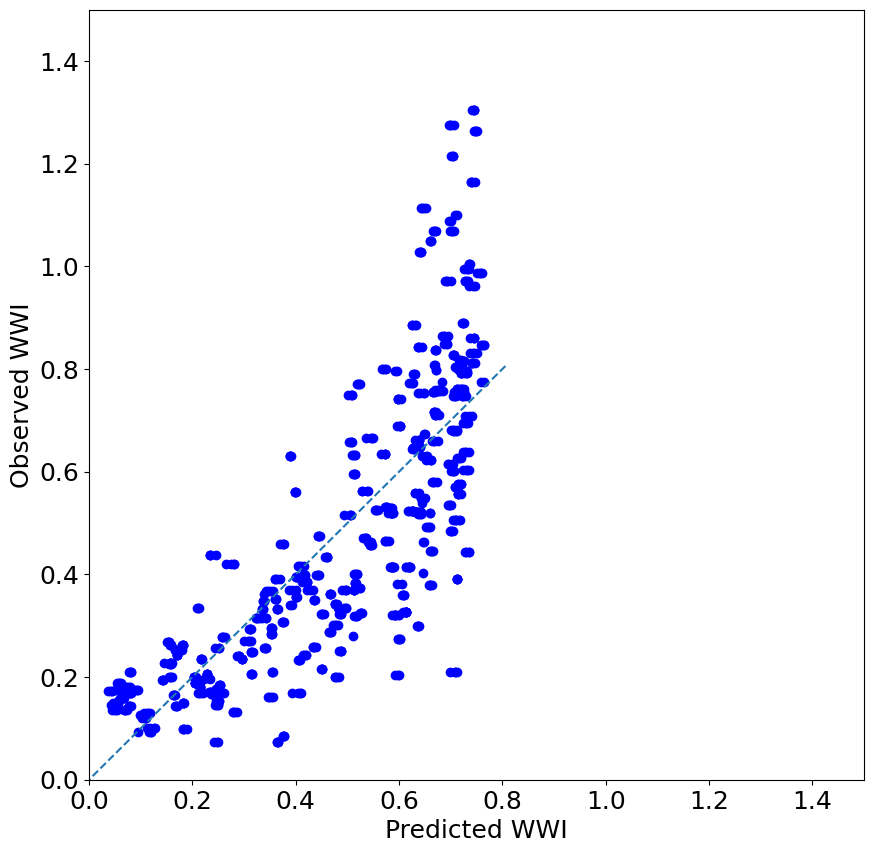

In [102]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted WWI', 'Observed WWI', data=appended_data1, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted WWI', fontsize=18)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed WWI', fontsize=18)
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekday

In [103]:
data2=data1.loc[data1['max_weekday_am_pm_value'] < 10]
X1=np.asarray(data2[['popden','stv_rec_ratio']])
Y1=np.asarray(data2[['max_weekday_am_pm_value']])

In [104]:
Y1.shape

(935, 1)

In [105]:
ln_model(X1, Y1)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.159321771246347	Score Loss: 1.1711668160877928
	Train RMSE: 1.6027857947267656	Score RMSE: 1.6598093833945937
	Train MAPE: 49.329129684823855	Score MAPE: 54.42522217611049
	Train R2:   0.5912679092143276	Score R2: 0.451905201547922
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.1679176648389453	Score Loss: 1.144311111652277
	Train RMSE: 1.6174688247319775	Score RMSE: 1.524523298065478
	Train MAPE: 50.179887121224766	Score MAPE: 53.5091219486005
	Train R2:   0.5735945211666706	Score R2: 0.6399967515518508
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.1577342694638846	Score Loss: 1.2774412560777604
	Train RMSE: 1.5856913309325644	Score RMSE: 1.7991990772044621
	Train MAPE: 49.60385495864787	Score MAPE: 64.20686964103191
	Train R2:   0.5853195037314411	Score R2: 0.544450

In [106]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.head()

,Predicted Max AMIPMI,Observed Max AMIPMI
0,2.228049,1.433566
1,2.228049,1.433566
2,2.236541,1.210702
3,1.063357,6.337662
4,1.256049,0.624456


In [107]:
appended_data2['Predicted Max AMIPMI'].max()

7.608309152432303

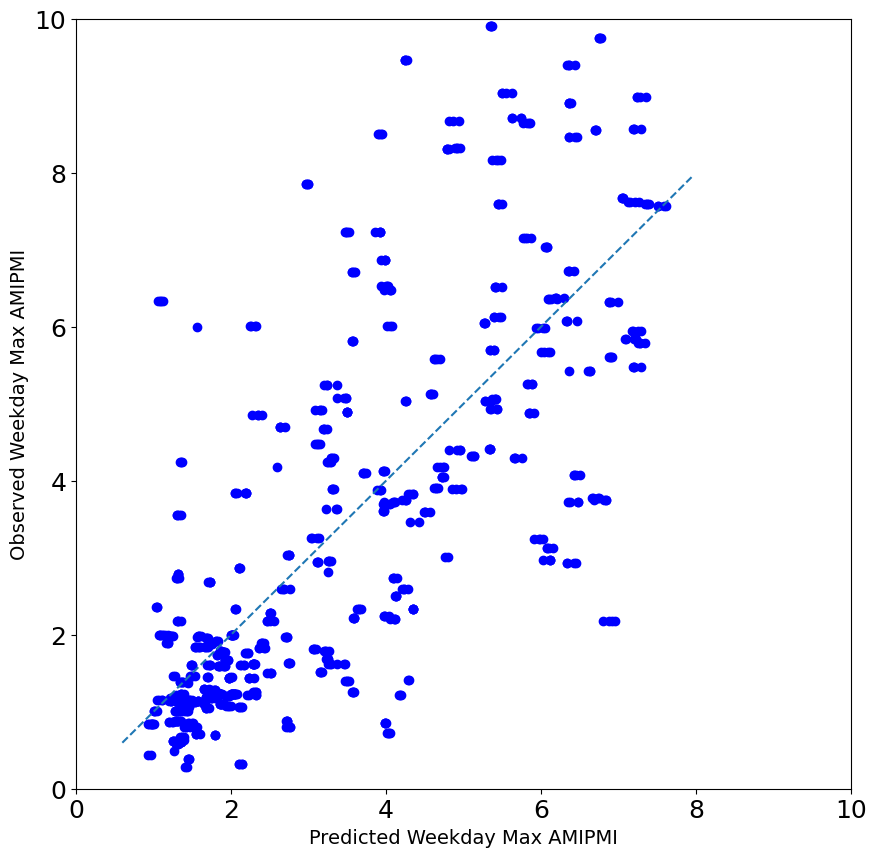

In [108]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data2, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekday Max AMIPMI', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekday Max AMIPMI', fontsize=14)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekend

In [109]:
data3=data1.loc[data1['max_weekend_am_pm_Value'] < 10]
X2=np.asarray(data3[['popden','stv_rec_ratio']])
Y2=np.asarray(data3[['max_weekend_am_pm_Value']])

In [110]:
ln_model(X2, Y2)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.2339935901761375	Score Loss: 0.2163893762614999
	Train RMSE: 0.3964099463979565	Score RMSE: 0.2892307141079808
	Train MAPE: 37.278356072812215	Score MAPE: 43.4581672277005
	Train R2:   0.004313459731050573	Score R2: 0.026052157446932234
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.22724342422107774	Score Loss: 0.2552833621452912
	Train RMSE: 0.380796416863338	Score RMSE: 0.4389956849022698
	Train MAPE: 37.63418421879187	Score MAPE: 33.75375904518387
	Train R2:   0.00822509698545082	Score R2: -0.01630376894325858
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.23606598115210098	Score Loss: 0.20392628425808929
	Train RMSE: 0.39804400876208135	Score RMSE: 0.26857026226249836
	Train MAPE: 36.198671320218295	Score MAPE: 55.06283870010257
	Train R2:   0.004298590527838653	S

In [111]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.head()

,Predicted Max AMIPMI,Observed Max AMIPMI
0,0.748132,0.386192
1,0.748289,0.423423
2,0.736555,1.674200
3,0.739071,0.557603
4,0.739071,0.557603


In [112]:
appended_data2['Observed Max AMIPMI'].max()

6.0

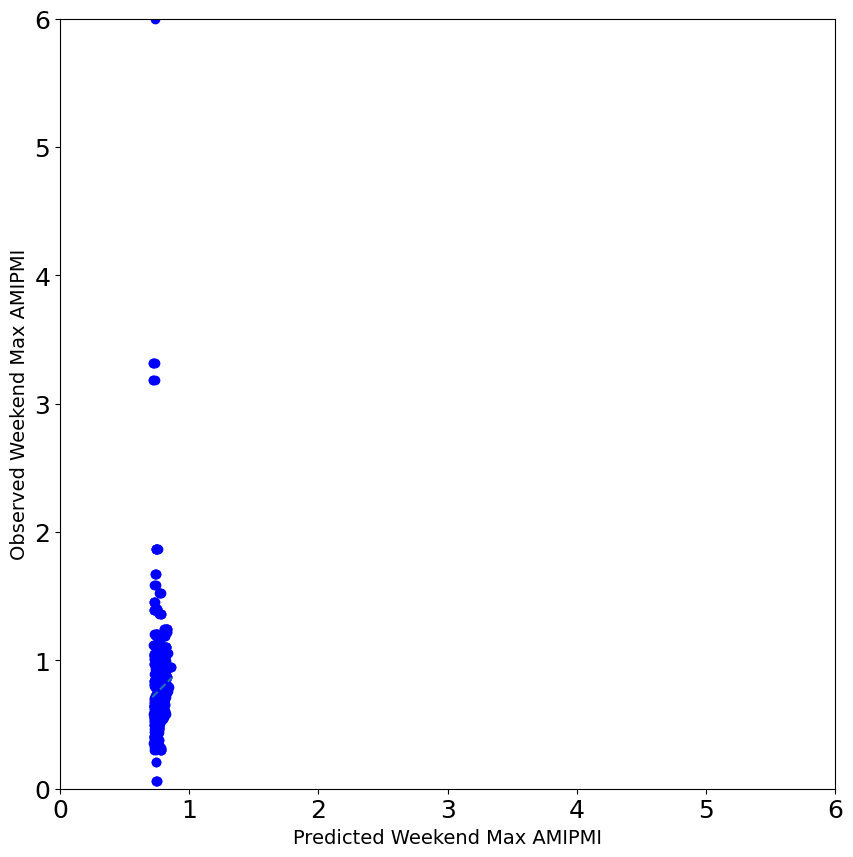

In [113]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data2, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekend Max AMIPMI', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekend Max AMIPMI', fontsize=14)
plt.xlim(0,6)
plt.ylim(0,6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# End of the Idices Prediction